#Errors in serial dilution: How can dispensing technology impact assay data?

####[Sonya M. Hanson and John D. Chodera](http://www.choderalab.org/) Computational Biology Program, Memorial Sloan Kettering Cancer Center, New York NY 10065

In a 2013 paper by Ekins et al, [Dispensing Processes Impact Apparent Biological Activity as Determined by Computational and Statistical Analyses. PLoS ONE 8(5): e62325, 2013](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0062325), a surprisingly large discrepancy in IC50 assay results is noted between the assay performed using a **Tecan Genesis** liquid handling workstation compared with a **LabCyte Echo** acoustic dispensing unit.

> *It would appear that tip-based dispensing is producing erroneous data based on our and other analyses which we see here reflected in the models and initial lack of correlations with molecular properties.*

This discrepancy was so large and so surprising that it was quickly picked up and discussed at length by numerous industry blogs, most notabley [In the Pipeline by Derek Lowe](http://pipeline.corante.com/archives/2013/05/03/drug_assay_numbers_all_over_the_place.php), which called the report a "truly disturbing paper".  Speculation abounded as to the precise cause: including sticky compounds, plastic leaching out of pipette tips, colloidal aggregation, miscalibrated pipettes, and sloppy experiments.  But could a simple physical process rooted in the intrinsic variability in the assay explain this difference?

In a biochemical or cell-based assay to determine the potency of a compound of interest, solutions of the compound at several concentrations are prepared and the the assay readout at a number of these concentrations can be fit to yield the $K_i$, IC50, or EC50 (depending on the assay configuration).

With a traditional manual assay or liquid handling workstation (such as the **Tecan Genesis**), the most straightforward approach to preparing a number of these compound concentrations is to prepare a **serial dilution series** starting from an original compound stock solution (often 10 mM stock in DMSO).  In a serial dilution, a volume $V_0$ of one solution is transferred into the next well and diluted with another volume $V_1$ of diluent, allowing a series of solutions spanning orders of magnitude in compound concentration to be prepared in a serial manner.

![alt text](img/serial.png "serial.png")

The **LabCyte Echo**, on the other hand, uses a direct dispensing technology to transfer a programmed volume (from 2.5 nL to microliters) directly into the assay wells, allowing a dilution series over several orders of magnitude in concentration to be created directly without the need for serial dilution.

![alt text](img/direct.png "direct.png")

While the Ekins paper explores the impact assay discrepancies has on QSAR models parameterized to the data, we focus here on the origin of the differences in assay results, and show how a simple model that captures the errors introduced at each step of the assay can lead us to identify the culprit behind the large discrepancy between the two assay configurations.  Understanding the origin of this discrepancy---which ends up being a source of bias in one of the assay configurations---can allow us to anticipate assay issues ahead of time, take steps to mitigate them, or even to correct for them after the fact.

Here, we introduce a simple kind of assay modeling in **this IPython notebook** that computational and experimental chemists alike can employ, as a tool that can easily be used to model and understand sources of uncertainty and  biases inherent in any experimental assay.  This kind of modeling could be used, for example, during assay development to ensure that the assay configuration will meet the dynamic range and accuracy needed for the assay, or it could be used after the fact by assay data consumers to understand the expected uncertainty and bias in the experimental dataset.

### 0. First we need to define our assay configuration.

In [1]:
# import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal
from scipy.interpolate import interp1d
%pylab inline
sns.set(style='white')
sns.set_context('talk')

Populating the interactive namespace from numpy and matplotlib


Our general assay configuration follows the description given in [2] (the source of the data used in Ekins et al.).  We assume that an 8-point dilution series was generated for use in the assay.  Suppose we start with an initial concentration of 10 mM in DMSO stock, and then serially dilute two fold to create final dilution volumes of 100 uL.

> [2] Bernard Christophe Barlaam, Richard Ducray. 2,4-diamino-pyrimidine derivatives. US Patent WO 2009010794 A1

#<span style="color:blue">insert figure here</span>
***[JDC: which figure?]***

We first define some of the parameters for the assay: the number of dilutions in the series, the working volume of each dilution, and the initial dilution concentration (which we take to be 100 uM, a reasonable upper concentration suggested by the patent data in [2]).

In [2]:
ndilutions = 8 # number of dilutions, including initial dilution
V0 = 100e-6 # working volume (L)
C0 = 100e-6 # initial dilution concentration (M)

We define specific parameters of the twofold serial dilution (transferring 50 $\mu$L into 50 $\mu$L buffer at each step):

In [3]:
Vtransfer = 50e-6 # volume transferred from previous dilution (L)
Vbuffer = 50e-6 # volume of diluent (buffer) added (L)

We next define a function that constructs the samples in the dilution series using a process similar to that used by the Tecan Genesis, assuming all volume transfers are performed without error:

In [4]:
def dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions):
    # Initialize concentrations and volumes with zero vectors with C0 and V0 as first value
    concentrations = numpy.zeros([ndilutions], numpy.float64)
    volumes = numpy.zeros([ndilutions], numpy.float64)
    concentrations[0] = C0
    volumes[0] = V0
    
    # and Vbuffer as initial volume for all but first.
    for n in range(1,ndilutions):
        volumes[n] = Vbuffer
        
    # Create dilution series.
    for n in range(1,ndilutions):
        concentrations[n] = concentrations[n-1] * Vtransfer / (Vtransfer + Vbuffer)
        volumes[n] += Vtransfer
        volumes[n-1] -= Vtransfer
        
    # Remove Vtransfer from last.
    volumes[ndilutions-1] -= Vtransfer
    
    return [volumes, concentrations]

Creating the dilution series with the parameters defined above produces an exact twofold dilution series:

In [5]:
[ideal_volumes, ideal_concentrations] = dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions)

In [6]:
print "We have an %s-point dilution series from %f uM to %f uM." % (ndilutions, ideal_concentrations.max()/1e-6, ideal_concentrations.min()/1e-6)

We have an 8-point dilution series from 100.000000 uM to 0.781250 uM.


We can plot the concentrations:

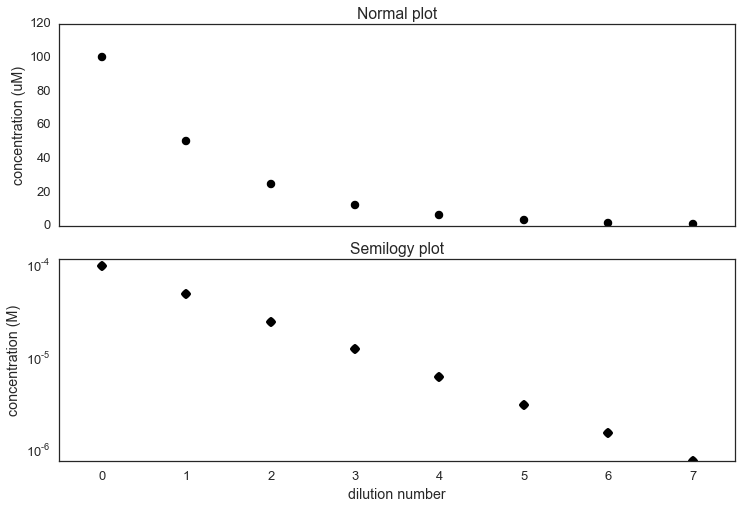

In [7]:
f, (ax1,ax2) = plt.subplots(2,1,sharex=True)
ax1.scatter(range(ndilutions), ideal_concentrations/1e-6, lw=4)
ax1.set_title("Normal plot")
ax1.set_ylabel('concentration (uM)')
ax1.axis([- 0.5, ndilutions - 0.5, 0.0, C0 * 1.2/1e-6])
ax2.semilogy(range(ndilutions), ideal_concentrations,'ko')
ax2.set_title("Semilogy plot")
ax2.set_ylabel('concentration (M)')
plt.xlabel('dilution number')
ax2.axis([- 0.5, ndilutions - 0.5, 0.0, C0 * 1.2])
f.tight_layout()

In reality, every experimental operation---such as a volume transfer---will be imperfect, leading to imperfect assay results.  We can model this---and its often surprising impact on the assay results---by making a simple model for the random and systematic variation with each operation.

### 1. Dilution and dispensing by a liquid-handling robot.

Real liquid-handling robots can't transfer the specified volume exactly. Each transfer operation has some (a) inaccuracy (modeled as a constant bias factor for all dispensing operations) and (b) imprecision (random error associated with each volume transfer). We'll ignore other contributions to error, such as compound stickiness, insolubility, etc. 

Suppose we generate this dilution series using a Tecan Genesis robot used in the assay.

Published manufacturer specifications for the imprecision of the Tecan Genesis are available online:

[imprecision data for Tecan Genesis](http://www.frankshospitalworkshop.com/equipment/documents/automated_analyzer/user_manuals/Tecan%20Genesis%20RMP%20-%20User%20manual.pdf)

Tecan does not generally publish inaccuracy specifications, however, since a well-calibrated instrument can essentially eliminate inaccuracy with custom corrections applied to different volume ranges.  In order to illustrate the role inaccuracy can play, we will instead employ inaccuracy data published for a similar class of liquid handling instrument---the Beckman NX/FX span-8:

[inaccuracy/imprecision data for Biomek NX/FX](https://www.beckmancoulter.com/wsrportal/bibliography?docname=BR-10150B.pdf)


#<span style="color:blue">insert chart from link here</span>

First, we define a pipetting error function for the genesis:

In [8]:
def tecan_genesis_pipetting_model(volume):
    # Imprecision from Tecan Genesis manual.
    # Inaccuracy estimated from Beckman Biomek NX/FX span-8.
    
    imprecision_function = interp1d(
        [1.5e-6,100e-6], # volume range (L)
        [0.03, 0.005]) # published relative imprecision for corresponding volumes Tecan Genesis
    inaccuracy_function = interp1d(
        [0.5e-6, 1e-6, 100e-6], # volume range (L)
        [0.05, 0.03, 0.03]) # published relative inaccuracies for corresponding volumesfor Beckman NX/FX span-8
    
    return [inaccuracy_function(volume), imprecision_function(volume)]    

Just for reference, this is what the ideal pipetting model looks like in comparison:

In [9]:
def ideal_pipetting_model(volume):

    imprecision_function = interp1d(
        [1.5e-6, 100e-6], # volume range (L)
        [0.0, 0.0]) # relative imprecision for corresponding volumes
    inaccuracy_function = interp1d(
        [0.5e-6, 1e-6, 100e-6], # volume range (L)
        [0.0, 0.0, 0.0]) # relative inaccuracies for corresponding volimes
    
    return [inaccuracy_function(volume), imprecision_function(volume)]    

#<span style="color:blue">Add better description of what is changing.</span>

Now consider a single *realization* of the automated pipetting process to generate a dilution series, utilizing the robot pipetting imprecision and inaccuracy model we defined above.

***[JDC: We should also model the uncertainty in the first concentration, assuming we transfer in 10 uL of 10 mM stock and 90 uL of buffer.]***

In [10]:
# define ROBOT_dilution_series function
def ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, pipetting_model):
    
    # use pipetting error function
    [transfer_inaccuracy, transfer_imprecision] = pipetting_model(Vtransfer)    
            
    # define (b) imprecision of volume transfer operations (including initial volumes)
    transfer_bias = transfer_inaccuracy * normal()
    
    # Initialize concentrations and volumes with zero vectors with C0 and V0 as first value
    actual_concentrations = numpy.zeros([ndilutions], numpy.float64)
    actual_volumes = numpy.zeros([ndilutions], numpy.float64)
    actual_concentrations[0] = C0
    actual_volumes[0] = V0
    
    # and Vbuffer as initial volume for all but first.
    Vbuffer_actual = Vbuffer * ((1+transfer_bias) + transfer_imprecision*normal())
    for n in range(1,ndilutions):
        actual_volumes[n] = Vbuffer_actual
    
    # Create dilution series.
    for n in range(1,ndilutions):
        Vtransfer_actual = Vtransfer * ((1+transfer_bias) + transfer_imprecision*normal())
        actual_concentrations[n] = \
            actual_concentrations[n-1] * Vtransfer_actual / (Vtransfer_actual + Vbuffer_actual)
        actual_volumes[n] += Vtransfer_actual
        actual_volumes[n-1] -= Vtransfer_actual
    Vtransfer_actual = Vtransfer * ((1+transfer_bias) + transfer_imprecision*normal())
    
    # Remove Vtransfer from last.
    actual_volumes[ndilutions-1] -= Vtransfer_actual
    
    return [actual_volumes, actual_concentrations]

In [11]:
[actual_volumes, actual_concentrations] = \
    ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)

We can visualize the deviations in concentrations generated by this imprecision and inaccuracy for this single realization.

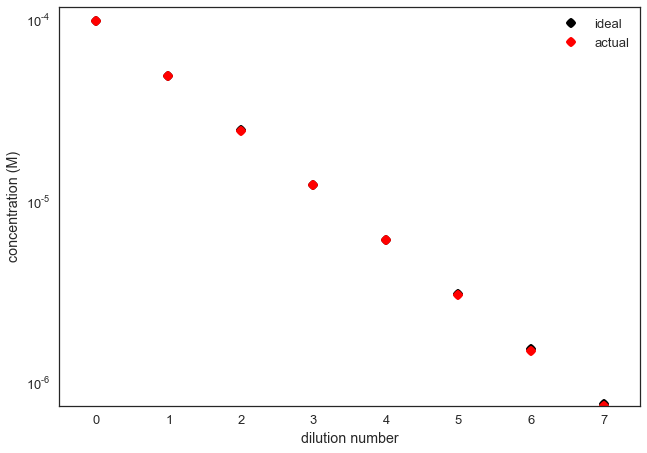

In [12]:
plt.semilogy(range(ndilutions), ideal_concentrations, 'ko', range(ndilutions), actual_concentrations, 'ro');
plt.xlabel('dilution number');
plt.ylabel('concentration (M)');
plt.legend(['ideal','actual']);
plt.axis([-0.5, ndilutions - 0.5, 0.0, C0 * 1.2]);

Note the trend that the magnitude of the concentration error increases with subsequent dilutions.  To better see this effect, we plot the relative errors in concentration, volume, and total quantity of compound per well.

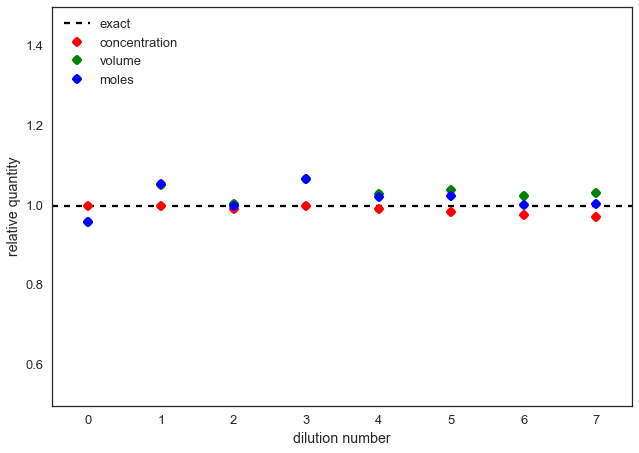

In [13]:
plt.plot([-0.5, ndilutions], [1, 1], 'k--');
plt.plot(range(ndilutions), actual_concentrations / ideal_concentrations, 'ro', \
         range(ndilutions), actual_volumes / ideal_volumes, 'go', \
         range(ndilutions), (actual_volumes*actual_concentrations)/(ideal_volumes*ideal_concentrations), 'bo');
plt.legend(['exact', 'concentration', 'volume', 'moles'], loc='upper left');
plt.axis([-0.5, ndilutions - 0.5, 0.5, 1.5]);
plt.ylabel('relative quantity');
plt.xlabel('dilution number');

Since this was only a single *realization* of the pipetting process, it is difficult to draw conclusions about the *typical* errors in creating a dilution series with a liquid handler.  We can do this by simulating *many* independent realizations of the same experiment, and then estimate the **coefficient of variation (CV)** from the variation among experiments.

Let's repeat the experiment 5000 times:

In [14]:
nreplicates = 5000

actual_volumes_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)
actual_concentrations_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)

for replicate in range(nreplicates):
    [actual_volumes_replicate, actual_concentrations_replicate] = \
        ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)
        
    actual_volumes_n[replicate,:] = actual_volumes_replicate
    actual_concentrations_n[replicate,:] = actual_concentrations_replicate

Now let's use this to compute the CV, using numpy.std, which calculates the standard deviation:

In [15]:
volumes_cv = (actual_volumes_n / ideal_volumes).std(0)
concentrations_cv = (actual_concentrations_n / ideal_concentrations).std(0)
quantity_cv = ((actual_volumes_n * actual_concentrations_n) / (ideal_volumes * ideal_concentrations)).std(0)

Plotting the CV as a function of dilution number reveals surprising trends.

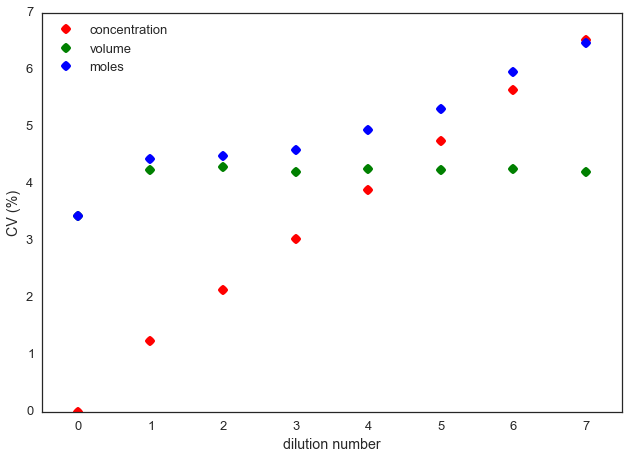

In [16]:
plt.plot(range(ndilutions), concentrations_cv*100, 'ro', \
         range(ndilutions), volumes_cv*100, 'go', \
         range(ndilutions), quantity_cv*100, 'bo')
plt.xlabel('dilution number')
plt.ylabel('CV (%)')
plt.xlim([-0.5, ndilutions - 0.5])
plt.legend(['concentration', 'volume', 'moles'], loc='upper left');

While the error in volume is relatively constant with dilution number, the CV (imprecision) in both concentration (molar) and quantity (moles) increases with dilution number.

What about bias?  Is there significant deviation from the expected average concentration due to this process?

Let's look at the mean of all these values for this 5000 replicate test.

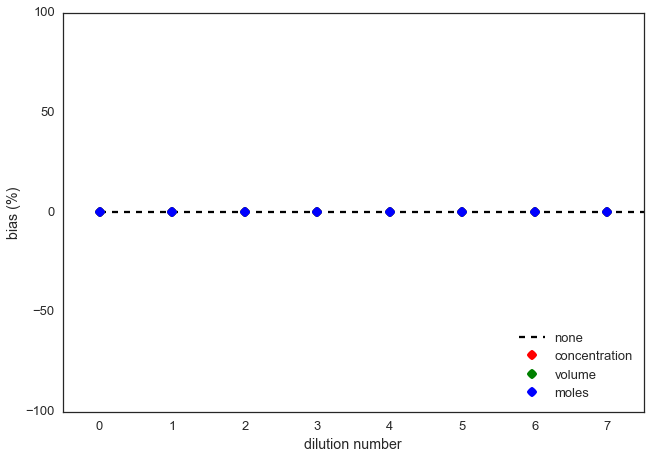

In [17]:
# Compute relative bias.
volumes_bias = (actual_volumes_n / ideal_volumes).mean(0) - 1
concentrations_bias = (actual_concentrations_n / ideal_concentrations).mean(0) - 1
quantity_bias = ((actual_volumes_n * actual_concentrations_n) / (ideal_volumes * ideal_concentrations)).mean(0)- 1

#Let's define DILUTIONS to make plotting easier.
dilutions = numpy.arange(ndilutions)

# Plot relative biases.
plt.plot([0, ndilutions], [0, 0], 'k--', dilutions, concentrations_bias*100, 'ro', \
     dilutions, volumes_bias*100, 'go', dilutions, quantity_bias*100, 'bo')
plt.xlabel('dilution number')
plt.ylabel('bias (%)')
plt.legend(['none','concentration', 'volume', 'moles'], loc='lower right')
plt.axis([-0.5, ndilutions - 0.5, -100, 100]);

We see that the process is essentially free of bias, which is expected if the bias for each realization of the experiment is chosen randomly for this model.  In reality, if multiple experiments are run with the same instrument without recalibration, the same bias in dispensing volumes would lead to biased assay results, but for the purposes of this simulation, we are sampling over many random recalibrations of the same instrument.

###Bias in pipetting with fixed tips due to dilution by system liquid

The Tecan Genesis supports the use of both disposable tips and fixed tips. When operating with fixed tips, syringes use a system liquid (generally water or buffer) to aspirate and dispense during liquid transfers.  While an air gap remains between the liquid being transferred and the system liquid, the system liquid is used to flush the tips into waste after transfers in order to remove any liquid residue before the next transfer.

Because a small quantity of system liquid residue remains coating the tip after washing, fixed tips can actually *dilute* the sample being transferred unless special protocols are used to prevent this.  The magnitude of this dilutione effect was noted in a 2006 paper by Dong et al at BMS, [The use of a dual dye photometric calibration method to identify possible sample dilution from an automated multichannel liquid-handling system. J. Lab. Autom. 11(2): 2006](http://dx.doi.org/10.1016/j.jala.2006.02.005), which quite surprisingly can have a large impact on dilution series preparation.

We introduce a modified model of the creation of our dilution series that incorporates this dilution effect.

In [18]:
# Define a function to interpolate the dilution effect between the measured values of Dong et al. 2006
volume = numpy.array([20, 200]) * 1e-6 # volumes at which dilution effect was quantified (L)
dilution_effect = numpy.array([-0.0630, -0.0496]) # relative inaccuracy due to dilution with system liquid at corresponding volumes
dilution_function = interp1d(volume, dilution_effect) # interpolation function

In [19]:
# define DILUTE_ROBOT_dilution_series function
def DILUTE_ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, pipetting_model):
    
    # use pipetting error function
    [transfer_inaccuracy, transfer_imprecision] = pipetting_model(Vtransfer)    
            
    # define (b) imprecision of volume transfer operations (including initial volumes)
    transfer_bias = transfer_inaccuracy * normal()
    
    # Initialize concentrations and volumes with zero vectors with C0 and V0 as first value
    actual_concentrations = numpy.zeros([ndilutions], numpy.float64)
    actual_volumes = numpy.zeros([ndilutions], numpy.float64)
    actual_concentrations[0] = C0
    actual_volumes[0] = V0
    
    # and Vbuffer as initial volume for all but first.
    Vbuffer_actual = Vbuffer * ((1+transfer_bias) + transfer_imprecision*normal())
    for n in range(1,ndilutions):
        actual_volumes[n] = Vbuffer_actual
    
    # Create dilute dilution series 
    # Observe only change is in actual_concentrations[n].
    for n in range(1,ndilutions):
        Vtransfer_actual = Vtransfer * ((1+transfer_bias) + transfer_imprecision*normal())
        actual_concentrations[n] = \
             actual_concentrations[n-1] * Vtransfer_actual / (Vtransfer_actual + Vbuffer_actual)\
             * (1+dilution_function(Vtransfer))
        actual_volumes[n] += Vtransfer_actual 
        actual_volumes[n-1] -= Vtransfer_actual
    Vtransfer_actual = Vtransfer * ((1+transfer_bias) + transfer_imprecision*normal())
    
    #Remove Vtransfer from last.
    actual_volumes[ndilutions-1] -= Vtransfer_actual
    
    return [actual_volumes, actual_concentrations]

Once again, we simulate many replicates of the same experiment, this time including the dilution effect.

In [20]:
nreplicates = 5000

actual_volumes_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)
actual_concentrations_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)

for replicate in range(nreplicates):
    [actual_volumes_replicate, actual_concentrations_replicate] = DILUTE_ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)
    actual_volumes_n[replicate,:] = actual_volumes_replicate
    actual_concentrations_n[replicate,:] = actual_concentrations_replicate

We can quantify the impact on imprecision by visualizing the CVs as a function of dilution number.

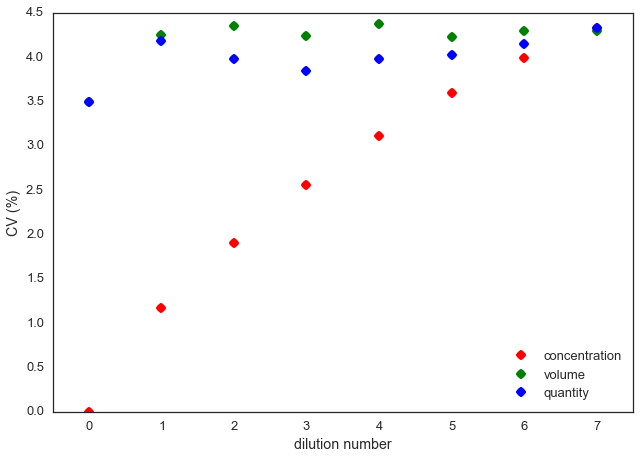

In [21]:
volumes_cv = (actual_volumes_n / ideal_volumes).std(0)
concentrations_cv = (actual_concentrations_n / ideal_concentrations).std(0)
quantity_cv = ((actual_volumes_n * actual_concentrations_n) / (ideal_volumes * ideal_concentrations)).std(0)

# Plot CVs
plt.plot(dilutions, concentrations_cv*100, 'ro', dilutions, volumes_cv*100, 'go', dilutions, quantity_cv*100, 'bo')
plt.xlabel('dilution number')
plt.ylabel('CV (%)')
plt.xlim([-0.5, ndilutions -0.5])
plt.legend(['concentration', 'volume', 'quantity'], loc='lower right');

We also examine the bias.

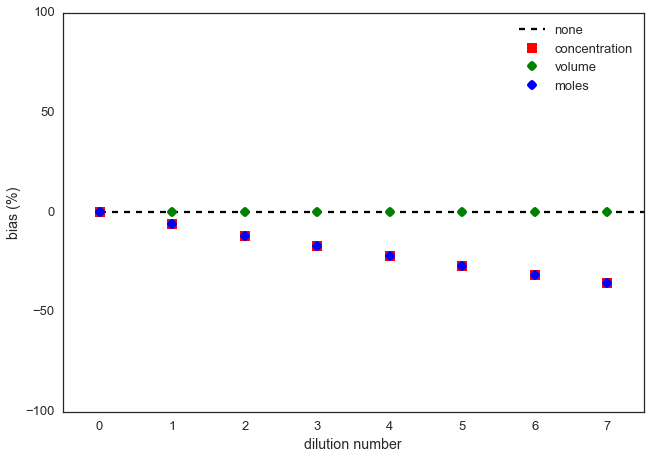

In [22]:
# Compute relative bias.
volumes_bias = (actual_volumes_n / ideal_volumes).mean(0) - 1
concentrations_bias = (actual_concentrations_n / ideal_concentrations).mean(0) - 1
quantity_bias = ((actual_volumes_n * actual_concentrations_n) / (ideal_volumes * ideal_concentrations)).mean(0)- 1

# Plot relative biases.
plt.plot([0, ndilutions], [0, 0], 'k--', dilutions, concentrations_bias*100, 'rs',\
     dilutions, volumes_bias*100, 'go', dilutions, quantity_bias*100, 'bo');
plt.xlabel('dilution number');
plt.ylabel('bias (%)');
plt.legend(['none', 'concentration', 'volume', 'moles'], loc='upper right');
plt.axis([-0.5, ndilutions - 0.5, -100, 100]);

We now see that over many realizations with random calibrations, significant bias in both the concentration (molarity) and quantity (moles of compound) accumulates with dilution number.

### 2. Dispensing by direct dispensing with the LabCyte Echo.

Preparation of a dilution series by direct dispensing with the LabCyte Echo is a different process.  In the protocol described in [2], various quantities of 10 mM stock up to 120 uL were dispensed using the Echo, and then backfilled to 120 uL with DMSO.

According to published [inaccuracy/imprecision specifications for LabCyte Echo](http://www.labcyte.com/sites/default/files/support_docs/Echo%205XX%20Specifications.pdf), the Echo has an inaccuracy of 10% and an imprecision of 8% over the entire dispense range of 2.5 nL to 10 uL.  We consider a 9-point dilution series spanning 2.5 nL (the smallest quantity the Echo can dispense) to 120 nL (the largest quantity dispensed in the assay) from 10 mM stock solution.

***[JDC: Why not 8-point?]***

#<span style="color:blue">insert figure here</span>

Define DMSO compound stock concentration as 10 mM:

In [23]:
C0 = 10e-3 # DMSO stock concentration (M)

Define final assay volume as 12 uL (note that ideal assay volume here is different than the working volume for the serial dilution series preparation):

In [24]:
assay_volume = 12e-6 # final assay volume (L)

Define 9-point titration (multiples of 2.5 nL):

In [25]:
echo_dispense_volumes = 2.5e-9 * numpy.array([6, 12, 18, 24, 30, 36, 42, 48])

Define the concentrations in this titration:

In [26]:
ideal_concentrations = (C0*echo_dispense_volumes/assay_volume)

To make sure our DMSO concentration does not vary as we vary our compound concentration, we'll always backfill up to 120 nL total DMSO:

In [27]:
backfill_volume = 120e-9 # total Echo dispense volume including compound and DMSO backfilling (L)

Define the mix volume (the volume of enzyme mix added to the assay) as assay_volume - backfill_volume, e.g. 12 uL assay volume minus 120 uL:

In [28]:
mix_volume = assay_volume - backfill_volume # assay mix volume to be added by liquid handler (L)

In [29]:
# define echo_assay_dispense function that mimics the process of dispensing from the Echo into mix_volume
def echo_assay_dispense(C0, mix_volume, backfill_volume, dispense_volumes):
    inaccuracy = 0.10
    imprecision = 0.08

    ndilutions = len(dispense_volumes)
    echo_volume = numpy.zeros([ndilutions], numpy.float64)
    echo_concentration = numpy.zeros([ndilutions], numpy.float64)
    bias = inaccuracy * normal()
    
    for i in range(ndilutions):
        compound_volume_intended = dispense_volumes[i]
        backfill_volume_intended = backfill_volume - compound_volume_intended
        
        compound_volume_dispensed = compound_volume_intended * ((1+bias) + imprecision*normal())
        backfill_volume_dispensed = backfill_volume_intended * ((1+bias) + imprecision*normal())
        
        echo_volume[i] = mix_volume + backfill_volume_dispensed + compound_volume_dispensed
        echo_concentration[i] = C0 * compound_volume_dispensed / echo_volume[i]

    return [echo_volume, echo_concentration]

In [30]:
[echo_volumes, echo_concentrations] = echo_assay_dispense(C0, mix_volume, backfill_volume, echo_dispense_volumes)

Let's plot a single realization of an Echo dispense experiment:

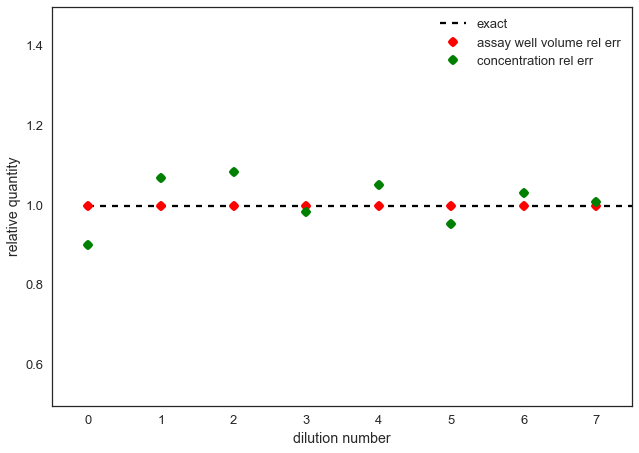

In [31]:
plt.plot([0,ndilutions], [1, 1], 'k--', range(ndilutions), echo_volumes / assay_volume,'ro',\
         range(ndilutions), echo_concentrations / ideal_concentrations, 'go');
plt.legend(['exact', 'assay well volume rel err', 'concentration rel err'], loc='upper right')
plt.axis([-0.5, ndilutions - 0.5, 0.5, 1.5])
plt.ylabel('relative quantity')
plt.xlabel('dilution number');

We simulate many realizations of the same experiment to quantify imprecision and bias in the dilution series.

In [32]:
nreplicates = 5000

actual_volumes_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)
actual_concentrations_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)

ndilutions = len(echo_dispense_volumes)
volume_array = numpy.ones([ndilutions]) * assay_volume

for replicate in range(nreplicates):
    [actual_volumes_replicate, actual_concentrations_replicate] = echo_assay_dispense(C0, mix_volume, backfill_volume, echo_dispense_volumes)
    actual_volumes_n[replicate,:] = actual_volumes_replicate
    actual_concentrations_n[replicate,:] = actual_concentrations_replicate
volumes_cv = (actual_volumes_n / assay_volume).std(0)
concentrations_cv = (actual_concentrations_n / ideal_concentrations).std(0)
quantity_cv = ((actual_volumes_n * actual_concentrations_n) / (assay_volume * ideal_concentrations)).std(0)

We can now plot the CVs to examine the imprecision in the resulting compound concentrations.

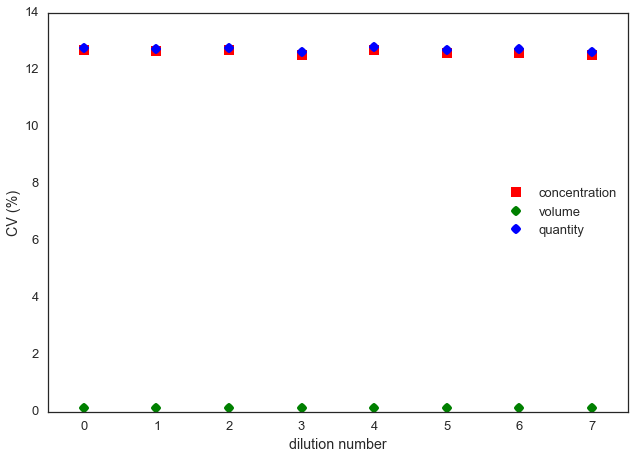

In [33]:
#Let's define DILUTIONS to make plotting easier.
dilutions = numpy.arange(ndilutions)

plt.plot(dilutions, concentrations_cv*100, 'rs', dilutions, volumes_cv*100, 'go', dilutions, quantity_cv*100, 'bo')
plt.xlabel('dilution number')
plt.ylabel('CV (%)')
plt.xlim([-0.5,ndilutions - 0.5])
plt.legend(['concentration', 'volume', 'quantity'], loc='center right');

We again quantify the bias:

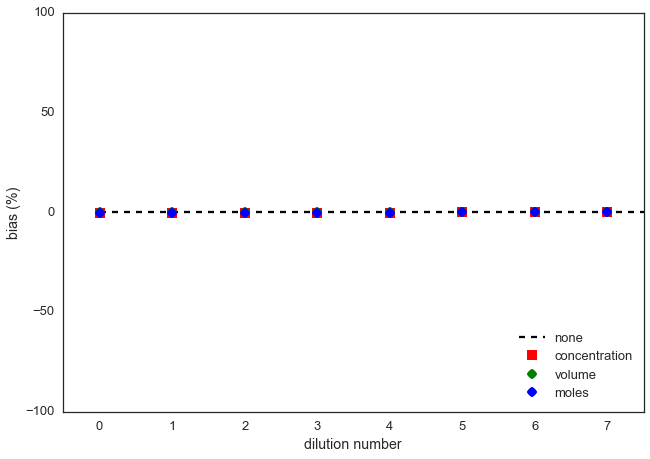

In [34]:
# Compute relative bias.
volumes_bias = (actual_volumes_n / assay_volume).mean(0) - 1
concentrations_bias = (actual_concentrations_n / ideal_concentrations).mean(0) - 1
quantity_bias = ((actual_volumes_n * actual_concentrations_n) / (assay_volume * ideal_concentrations)).mean(0)- 1

# Plot relative biases.
plt.plot([0, ndilutions], [0, 0], 'k--', dilutions, concentrations_bias*100, 'rs', \
     dilutions, volumes_bias*100, 'go', dilutions, quantity_bias*100, 'bo')
plt.xlabel('dilution number')
plt.ylabel('bias (%)')
plt.legend(['none','concentration', 'volume', 'moles'], loc='lower right')
plt.axis([-0.5, ndilutions - 0.5, -100, 100]);

Again, bias over many random calibrations of the same instrument is expected to be zero.

#<span style="color:blue">Insert comparison here of two CVs and two biases.</span>

### 3. How do IC50 estimates between these compare?

Now lets see how these errors relate to IC50 results. Let's assume EphB4 as our system, with a Km for ATP by EphB4 of 1.71 uM ([EphB4 DataSheet](http://www.proqinase.com/kinase-database/pdfs/2843.pdf)). Note that we're assuming that EphB4 obeys Michaelis-Menten kinetics here, and that V0/Vmax is what is measured.

In [35]:
Km = 1.71e-6 # Km of ATP for EphB4 (M)

Let's assume true Ki for an arbitrary compound is 10 nM.

In [36]:
true_Ki = 10e-9 # arbitrary compound Ki (M)

Let's assume a substrate concentration of 4 µM ATP.

In [37]:
substrate_concentration = 4e-6 # ATP concentration (M)

Let's Assume 0.25 ng of ~42.4 kDa enzyme, which is ~ 6 µM.

In [38]:
enzyme_concentration = 6e-6 # EphB4 assay concentration (M)

We will dispense 2 µL of diluted compound into an assay plate well into which 10 µL of enzyme mix has been dispense. 

Define volume of compound to be dispensed as 2 µL:

In [39]:
compound_volume = 2.0e-6 # volume of compound dilution added to assay (L)

Define volume of enzyme mix into which this is dispesned as 10 µL:

In [40]:
mix_volume = 10.0e-6 # volume of enzyme assay mix added to assay (L)

Let's suppose the 10 uL of assay mix in each well was dispensed completely accurately, and contains exact concentrations of enzyme and substrate. We presume inhibition is measured by an exact read of the reaction V0/Vmax.

 The IC50 would be the interpolated point at which V0/Vmax drops to 0.5, as determined from a fit of the competitive inhibition equations to the observed V0/Vmax for the dilution series, using the ideal dilution series concentrations in the fit.

### 3A. IC50s for the Tecan Genesis

There is additional error since the imprecision at this volume is higher, so we will model that first.

We'll use our robot dilution series that includes the dilution effect.

In [41]:
ndilutions = 8
[ideal_volumes, ideal_concentrations] = dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions)
[actual_volumes, actual_concentrations] = \
    DILUTE_ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)

Then make a more accurate function that takes into account the mixing volume and incorporates our *tecan_genesis_pipetting_model*.

In [42]:
def robot_dispense(compound_volume, mix_volume, compound_concentrations, pipetting_model):
    [compound_inaccuracy, compound_imprecision] = pipetting_model(compound_volume)
    [mix_inaccuracy, mix_imprecision] = pipetting_model(mix_volume)
    
    from numpy.random import normal
    assay_volume = numpy.zeros([ndilutions], numpy.float64)
    assay_compound_concentration = numpy.zeros([ndilutions], numpy.float64)
    
    compound_bias = compound_inaccuracy * normal()
    mix_bias = mix_inaccuracy * normal()

    for i in range(ndilutions):
        compound_volume_dispensed = compound_volume * ((1+compound_bias) + compound_imprecision*normal())
        mix_volume_dispensed = mix_volume * ((1+mix_bias) + mix_imprecision*normal())
        assay_volume[i] = compound_volume_dispensed + mix_volume_dispensed
        assay_compound_concentration[i] = compound_concentrations[i] * compound_volume_dispensed / assay_volume[i]

    return [assay_volume, assay_compound_concentration]

In [43]:
[assay_volumes, assay_compound_concentrations] = \
robot_dispense(compound_volume, mix_volume, actual_concentrations, tecan_genesis_pipetting_model)

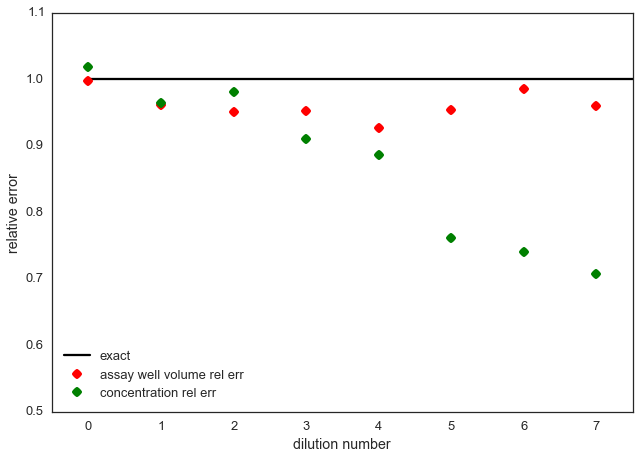

In [44]:
plt.plot([0,ndilutions], [1, 1], 'k-', range(ndilutions), assay_volumes / (compound_volume+mix_volume), 'ro', \
         range(ndilutions), assay_compound_concentrations / (ideal_concentrations*compound_volume/(compound_volume+mix_volume)), 'go');
plt.legend(['exact', 'assay well volume rel err', 'concentration rel err'], loc='lower left');
plt.xlabel('dilution number');
plt.ylabel('relative error');
plt.axis([-0.5, ndilutions - 0.5, 0.5, 1.1]);

We define a simple model for competitive inhibition in an enzyme assay, where catalysis obeys Michaelis-Menten kinetics.  We presume that our assay readout is $V_0/V_{max}$, the ratio if initial enzyme turnover velocity to the maximum turnover velocity, which might be read as the rate of production of some sort of fluorescent product or depletion of a fluorescent substrate.

In [45]:
def competitive_inhibition(substrate_concentration, inhibitor_concentration, enzyme_concentration, Ki, Km):
    V0_over_Vmax = substrate_concentration / (Km*(1 + inhibitor_concentration/Ki) + substrate_concentration)
    return V0_over_Vmax

We can now model the observed assay readout (a measure of enzyme activity as a function of inhibitor concentration) for a single realization of the assay.

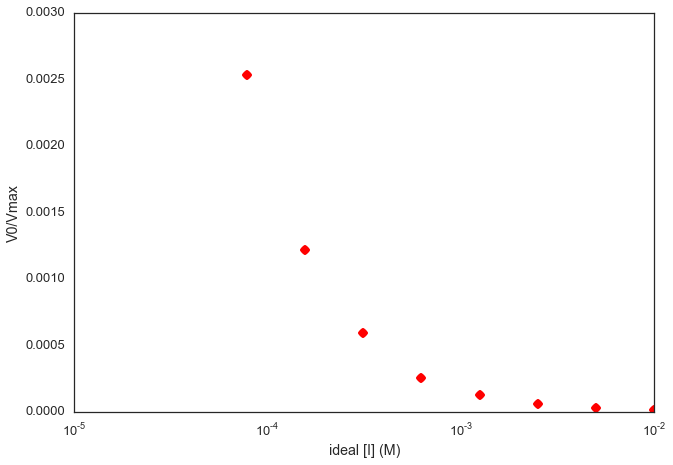

In [46]:
activity = numpy.zeros([ndilutions], numpy.float64)
for i in range(ndilutions):
    activity[i] = competitive_inhibition(substrate_concentration, assay_compound_concentrations[i], enzyme_concentration, true_Ki, Km)

plt.semilogx(ideal_concentrations, activity, 'ro');
plt.xlabel('ideal [I] (M)');
plt.ylabel('V0/Vmax');

What does this look like if we run many assay replicates?

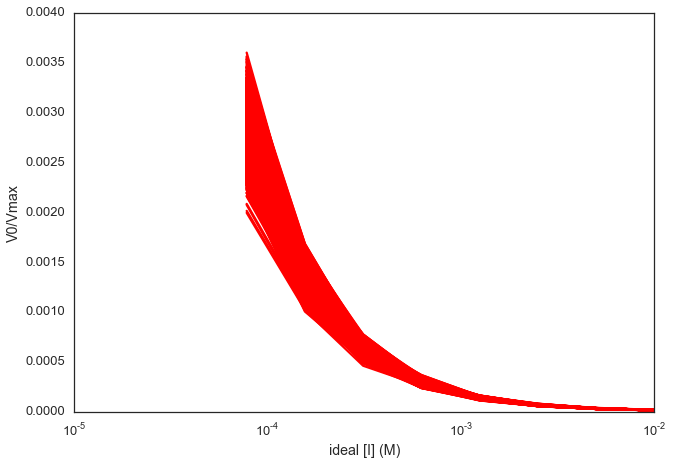

In [47]:
nreplicates = 5000
activity = numpy.zeros([nreplicates,ndilutions], numpy.float64)
for replicate in range(nreplicates):
    [actual_volumes, actual_concentrations] = DILUTE_ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)
    [assay_volumes, assay_concentrations] = robot_dispense(compound_volume, mix_volume, actual_concentrations, tecan_genesis_pipetting_model)
    for i in range(ndilutions):
        activity[replicate,i] = competitive_inhibition(substrate_concentration, assay_concentrations[i], enzyme_concentration, true_Ki, Km)


plt.semilogx(ideal_concentrations, activity.transpose(), 'r-');
plt.xlabel('ideal [I] (M)');
plt.ylabel('V0/Vmax');

It's not hard to see that the IC50 will vary over a substantial range.  To determine the distribution of IC50s consistent with the experimental errors, we use a nonlinear fit to each realization of the experiment to extract an IC50.

[]

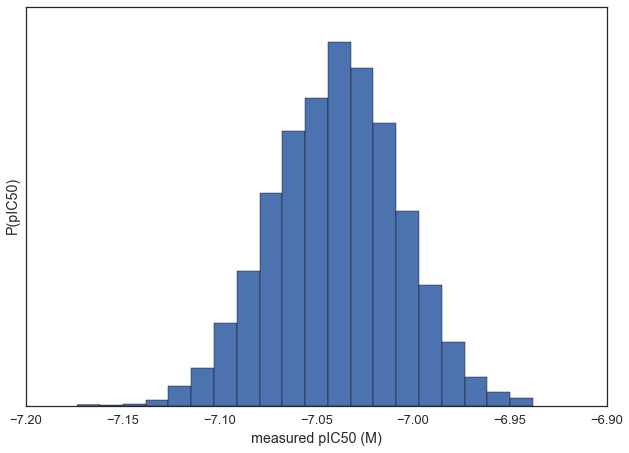

In [48]:
def fit_ic50(inhibitor_concentrations, activities):
    import numpy, scipy
    def objective(inhibitor_concentrations, Ki):
        activities = numpy.zeros([ndilutions], numpy.float64)
        for i in range(ndilutions):
            activities[i] = competitive_inhibition(substrate_concentration, inhibitor_concentrations[i], enzyme_concentration, Ki, Km)
        return activities
            
    Ki_guess = true_Ki
    import scipy.optimize
    [popt, pcov] = scipy.optimize.curve_fit(objective, inhibitor_concentrations, activities, p0=[Ki_guess])
    
    return popt[0]

IC50s_tips = numpy.zeros([nreplicates], numpy.float64)
for replicate in range(nreplicates):
    IC50s_tips[replicate] = fit_ic50(ideal_concentrations, activity[replicate,:])
pIC50s_tips = numpy.log10(IC50s_tips)
    
clf()
nhist = 20
hist(pIC50s_tips, nhist);
xlabel('measured pIC50 (M)');
ylabel('P(pIC50)');
gca().axes.get_yaxis().set_ticks([]); # turn off y ticks

The imprecision and inaccuracy in the measured pIC50s may not be uniform across the whole $K_i$ range, however.  To see if there is variation as a function of true inhibitor $K_i$, we can characterize imprecision and inaccuracy as a function of $pK_i$.

In [49]:
def robot_IC50s(true_Ki):
    nreplicates = 1000
    IC50s = numpy.zeros([nreplicates], numpy.float64)
    for replicate in range(nreplicates):
        [actual_volumes, actual_concentrations] = DILUTE_ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)
        [assay_volumes, assay_compound_concentrations] = robot_dispense(compound_volume, mix_volume, actual_concentrations, tecan_genesis_pipetting_model)
        activities = numpy.zeros([ndilutions], numpy.float64)
        for i in range(ndilutions):
            activities[i] = competitive_inhibition(substrate_concentration, assay_compound_concentrations[i], enzyme_concentration, true_Ki, Km)
        IC50s[replicate] = fit_ic50(ideal_concentrations, activities)
    return IC50s

pKis = numpy.array([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3], numpy.float64);
Kis = 10**pKis
nKis = len(pKis)
genesis_pIC50_bias = numpy.zeros([nKis], numpy.float64)
genesis_pIC50_CV = numpy.zeros([nKis], numpy.float64)
for (i, Ki) in enumerate(Kis):
    IC50s = robot_IC50s(Ki)    
    pIC50s = numpy.log10(IC50s)
    pKi = pKis[i]
    genesis_pIC50_bias[i] = pIC50s.mean() - pKi;
    genesis_pIC50_CV[i] = pIC50s.std() / abs(pIC50s.mean())    

We can plot the bias in the measured pIC50 values to examine the bias and CV.

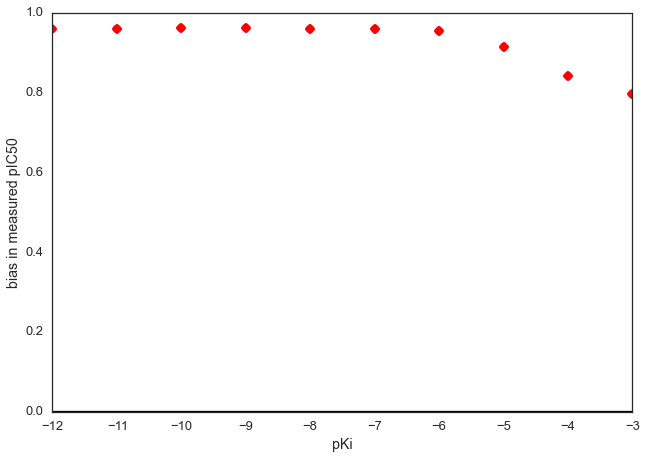

In [50]:
plot([pKis.min(), pKis.max()], [0, 0], 'k-', pKis, genesis_pIC50_bias, 'ro');
xlabel('pKi');
ylabel('bias in measured pIC50');

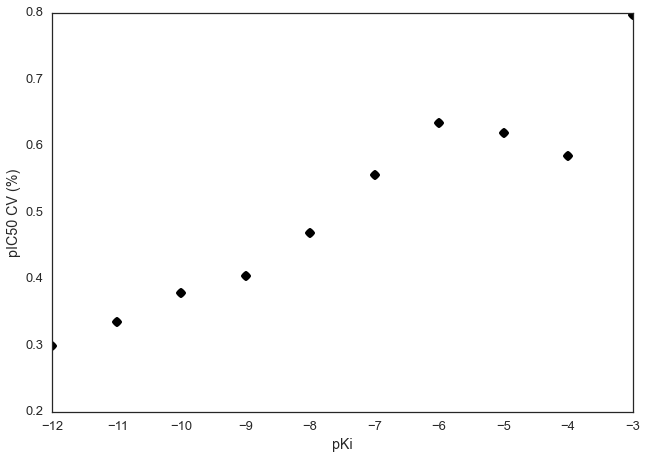

In [51]:
plot(pKis, genesis_pIC50_CV*100, 'ko');
xlabel('pKi');
ylabel('pIC50 CV (%)');
#axis([pKis.min(), pKis.max(), 0, 10]);

### 3B. IC50s for the LabCyte Echo

How does a competitive inhibition look with the narrow dynamic range afforded by the LabCyte Echo?

In [52]:
ideal_concentrations = (C0*echo_dispense_volumes/assay_volume)
[assay_volumes, assay_concentrations] = echo_assay_dispense(C0, mix_volume, backfill_volume, echo_dispense_volumes)

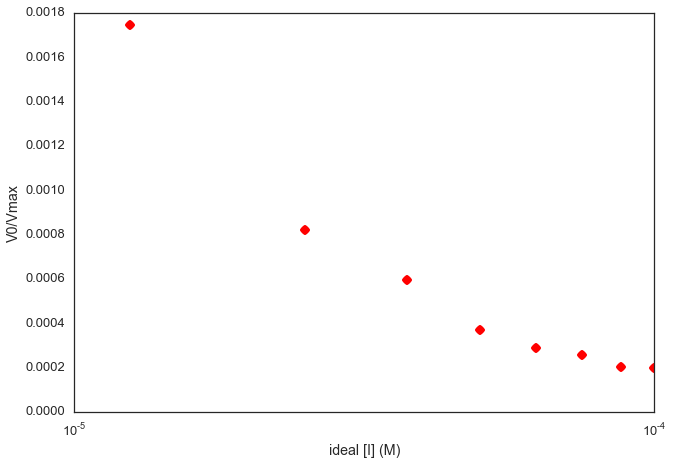

In [53]:
#echo
activity = numpy.zeros([ndilutions], numpy.float64)
for i in range(ndilutions):
    activity[i] = competitive_inhibition(substrate_concentration, assay_concentrations[i], enzyme_concentration, true_Ki, Km)

# Plot V0/Vmax for a single realization,
semilogx(ideal_concentrations, activity, 'ro');
xlabel('ideal [I] (M)');
ylabel('V0/Vmax');

V0 only goes up to a maximum of 0.012, but we can still see some curvature that could give a decent fit to Michaelis-Menten for an IC50. Let's try a number of replicates to see how much variation there is between measurements.

In [54]:
# JDC: DO WE NEED THIS?
nreplicates = 5000
actual_volumes_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)
actual_concentrations_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)
for replicate in range(nreplicates):
    [actual_volumes_replicate, actual_concentrations_replicate] = echo_assay_dispense(C0, mix_volume, backfill_volume, echo_dispense_volumes)
    actual_volumes_n[replicate,:] = actual_volumes_replicate
    actual_concentrations_n[replicate,:] = actual_concentrations_replicate

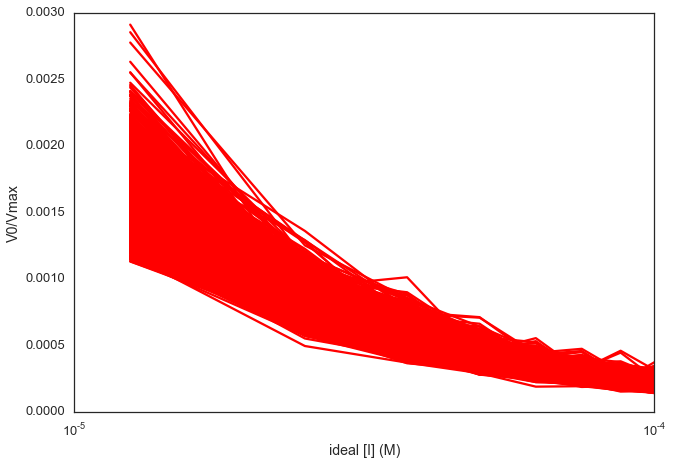

In [55]:
activity = numpy.zeros([nreplicates,ndilutions], numpy.float64)
for replicate in range(nreplicates):
    [assay_volumes, assay_compound_concentrations] = echo_assay_dispense(C0, mix_volume, backfill_volume, echo_dispense_volumes)
    for i in range(ndilutions):
        activity[replicate,i] = competitive_inhibition(substrate_concentration, assay_compound_concentrations[i], enzyme_concentration, true_Ki, Km)

# Plot V0/Vmax for many measurements.
semilogx(ideal_concentrations, activity.transpose(), 'r-');
xlabel('ideal [I] (M)');
ylabel('V0/Vmax');

We fit these to get the distribution of IC50s induced by the inaccuracy and imprecision in Echo dispensing.


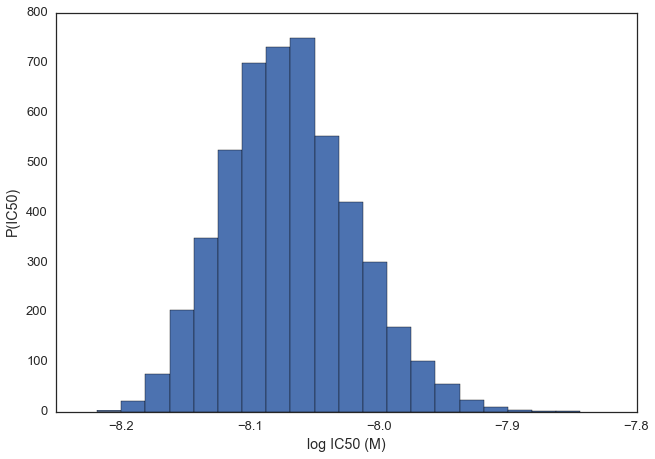

In [56]:
IC50s_echo = numpy.zeros([nreplicates], numpy.float64)
for replicate in range(nreplicates):
    IC50s_echo[replicate] = fit_ic50(ideal_concentrations, activity[replicate,:])

nhist = 20
hist(numpy.log10(IC50s_echo), nhist);
xlabel('log IC50 (M)');
ylabel('P(IC50)');

Let's characterize the error for the Echo assay as a function of Ki.

In [57]:
def echo_IC50s(true_Ki):
    nreplicates = 1000
    IC50s = numpy.zeros([nreplicates], numpy.float64)
    for replicate in range(nreplicates):
        [assay_volumes, assay_compound_concentrations] = echo_assay_dispense(C0, mix_volume, backfill_volume, echo_dispense_volumes)
        activities = numpy.zeros([ndilutions], numpy.float64)
        for i in range(ndilutions):
            activities[i] = competitive_inhibition(substrate_concentration, assay_compound_concentrations[i], enzyme_concentration, true_Ki, Km)
        IC50s[replicate] = fit_ic50(ideal_concentrations, activities)
    return IC50s

# Run simulation of many experiments.
pKis = numpy.array([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3], numpy.float64);
Kis = 10**pKis
nKis = len(pKis)
echo_pIC50_bias = numpy.zeros([nKis], numpy.float64)
echo_pIC50_CV = numpy.zeros([nKis], numpy.float64)
for (i, Ki) in enumerate(Kis):
    IC50s = echo_IC50s(Ki)    
    pIC50s = numpy.log10(IC50s)
    pKi = pKis[i]
    echo_pIC50_bias[i] = pIC50s.mean() - pKi;
    echo_pIC50_CV[i] = pIC50s.std() / abs(pIC50s.mean())    

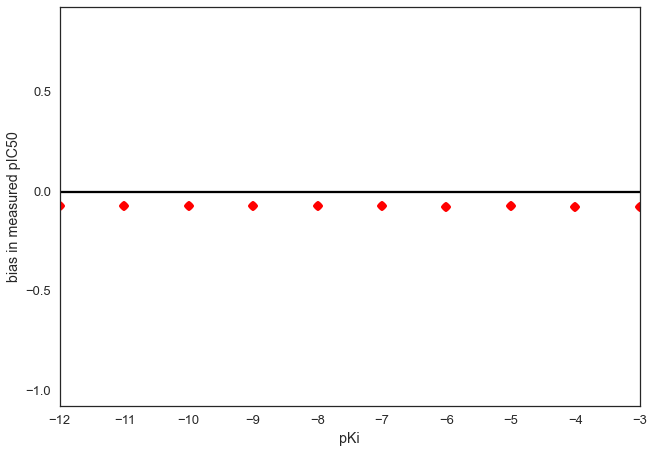

In [58]:
# Plot relative error in measured Ki values as a function of true Ki.
plot([pKis.min(), pKis.max()], [0, 0], 'k-', pKis, echo_pIC50_bias, 'ro');
xlabel('pKi');
ylabel('bias in measured pIC50');
axis([pKis.min(), pKis.max(), echo_pIC50_bias.min()-1, echo_pIC50_bias.max()+1]);

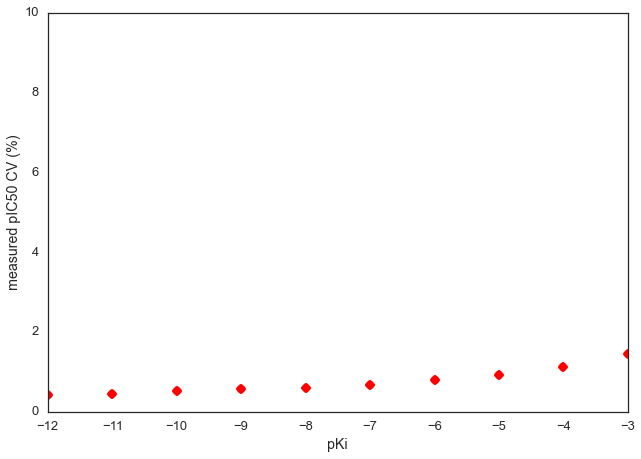

In [59]:
#Plot CV.
plot(pKis, echo_pIC50_CV*100, 'ro');
xlabel('pKi');
ylabel('measured pIC50 CV (%)');
axis([pKis.min(), pKis.max(), 0, 10]);

### 3C. Comparison of Tecan Genesis and LabCyte Echo modeled performance

What do we get when we plot the Tecan Genesis and Echo results against each other?

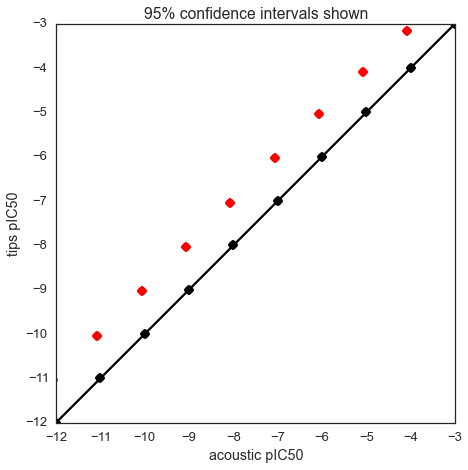

In [60]:
echo_pIC50_err = (echo_pIC50_CV*numpy.abs(pKis))
genesis_pIC50_err = (genesis_pIC50_CV*numpy.abs(pKis))

clf();
subplot(111, aspect='equal');
hold(True);
plot([pKis.min(), pKis.max()], [pKis.min(), pKis.max()], 'k-');
plot(pKis, pKis, 'ko');
errorbar(pKis + echo_pIC50_bias, pKis + genesis_pIC50_bias, xerr=2*echo_pIC50_err, yerr=2*genesis_pIC50_err, fmt='ro');
axis([pKis.min(), pKis.max(), pKis.min(), pKis.max()]);
xlabel('acoustic pIC50');
ylabel('tips pIC50');
title('95% confidence intervals shown');

In [61]:
# data from Fig 1 of Fregau et al.
echo_IC50s = numpy.array([0.064, 0.486, 0.003, 0.002, 0.007, 0.003, 0.004, 0.052, 0.01362, 0.207, 0.158, 0.01164, 0.00633, 0.00358]) * 1e-6 # M
genesis_IC50s = numpy.array([0.817, 3.03, 0.146, 0.553, 0.973, 0.778, 0.445, 0.17, 0.112, 14.4, 0.25, 0.049, 0.087, 0.152]) * 1e-6 # M

echo_pIC50s = numpy.log10(echo_IC50s);
genesis_pIC50s = numpy.log10(genesis_IC50s);

Let's add the error bars we modeled to see if the variation is sufficient to bring the two sets of data into agreement.

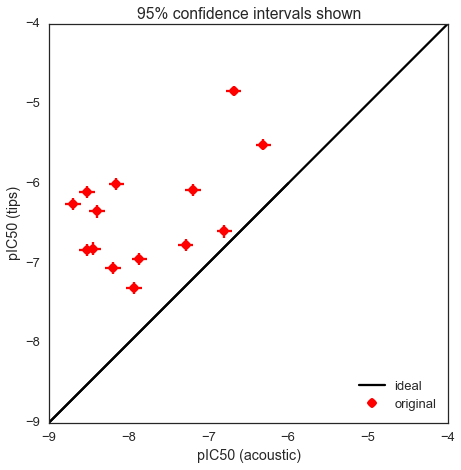

In [62]:
# Interpolate bias and CV for Echo and Genesis.
from scipy.interpolate import interp1d
echo_bias_interpolation = interp1d(pKis, echo_pIC50_bias);
echo_CV_interpolation = interp1d(pKis, echo_pIC50_CV);
genesis_bias_interpolation = interp1d(pKis, genesis_pIC50_bias);
genesis_CV_interpolation = interp1d(pKis, genesis_pIC50_CV);

# Compute error bars for Echo and Genesis.
echo_pIC50_err = (echo_CV_interpolation(echo_pIC50s)*numpy.abs(echo_pIC50s))
genesis_pIC50_err = (genesis_CV_interpolation(genesis_pIC50s)*numpy.abs(genesis_pIC50s))

# Plot with error bars.
figure();
subplot(111, aspect='equal');
hold(True);
plot([-9, -4], [-9, -4], 'k-');
errorbar(echo_pIC50s, genesis_pIC50s, xerr=2*echo_pIC50_err, yerr=2*genesis_pIC50_err, fmt='ro');
plot([-9, -6], [-9, -6], 'k-');
xlabel('pIC50 (acoustic)');
ylabel('pIC50 (tips)');
legend(['ideal', 'original'], loc='lower right');
title('95% confidence intervals shown');

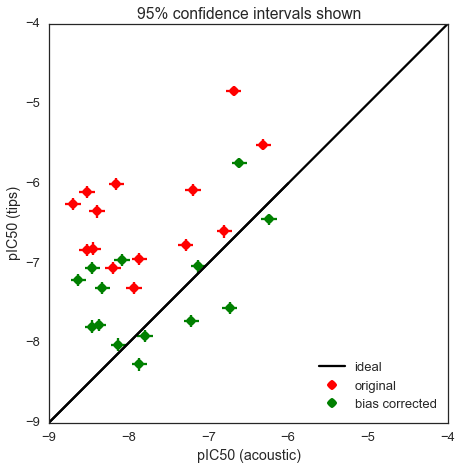

In [63]:
# Plot.
figure();
subplot(111, aspect='equal');
hold(True);
plot([-9, -4], [-9, -4], 'k-');
errorbar(echo_pIC50s, genesis_pIC50s, xerr=2*echo_pIC50_err, yerr=2*genesis_pIC50_err, fmt='ro');
errorbar(echo_pIC50s - echo_bias_interpolation(echo_pIC50s), genesis_pIC50s - genesis_bias_interpolation(genesis_pIC50s), xerr=2*echo_pIC50_err, yerr=2*genesis_pIC50_err, fmt='go');
plot([-9, -6], [-9, -6], 'k-');
xlabel('pIC50 (acoustic)');
ylabel('pIC50 (tips)');
legend(['ideal', 'original', 'bias corrected'], loc='lower right');
title('95% confidence intervals shown');

The assays are in much better agreement at this point, but it does not appear that the specified imprecision of the Tecan Genesis and Labcyte Echo are sufficient to explain the remaining discrepancies.

### 4. The HP D300 is an alternative digital dispensing device 